# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits' dataset.
Path to dataset files: /kaggle/input/fruits


In [2]:
# Importing libraries

import os   # For file and directory management
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
# Navigating to Fruits-360 dataset root directory
path = os.path.join(path, "fruits-360_100x100", "fruits-360")

In [4]:
os.listdir(path)

['LICENSE', 'Training', 'README.md', 'Test']

In [5]:
# Path to Training and Test dataset directory
training = os.path.join(path, "Training")
test = os.path.join(path, "Test")

In [6]:
# Takes Grayscale Image and returns the Local Binary Pattern Image

def get_lbp(gray):
   h, w  = gray.shape

   # Initialising lbp image
   lbp = np.zeros((h, w), dtype=np.uint8)

   # We could have done padding or wrap image around treating it as toroid to handle border pixels
   # But for Fruits-360 dataset with a uniform white background,
   # ignoring border pixels does not significantly affect the extracted LBP features

   for i in range(1, h-1):
       for j in range(1, w-1):
           center = gray[i, j]
           binary = 0
           # Calculating lbp code for pixel at [i, j]
           binary |= (gray[i-1, j-1] >= center) << 7
           binary |= (gray[i-1, j  ] >= center) << 6
           binary |= (gray[i-1, j+1] >= center) << 5
           binary |= (gray[i  , j+1] >= center) << 4
           binary |= (gray[i+1, j+1] >= center) << 3
           binary |= (gray[i+1, j  ] >= center) << 2
           binary |= (gray[i+1, j-1] >= center) << 1
           binary |= (gray[i  , j-1] >= center) << 0

           lbp[i, j] = binary

   return lbp

In [7]:
# Takes Grayscale Image and returns its Canny Edge Map

def get_canny(gray):
    canny = cv2.Canny(gray, 100, 200)
    return canny

In [8]:
# Let's start with little bit of visualisation

def visualize(path):
    # Read the image and conversion to RGB and Grayscale Image
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get LBP Feature Image
    lbp = get_lbp(gray)

    # Get Canny Edge Map
    canny = get_canny(gray)

    # Binary Mask & Contour Detection
    _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)  # Contour with largest area

    # Area Mask
    area_mask = np.zeros_like(gray)
    cv2.drawContours(area_mask, [cnt], -1, 255, -1)

    # Convex Hull
    hull = cv2.convexHull(cnt)
    img_hull = img.copy()
    cv2.drawContours(img_hull, [hull], -1, (255, 0, 0), 1)

    # Bounding Box (For Aspect ratio)
    x, y, w, h = cv2.boundingRect(cnt)
    img_box = img.copy()
    cv2.rectangle(img_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(img)                     # RGB Image
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(lbp, cmap="gray")        # LBP
    plt.title("LBP Feature Image")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(canny, cmap="gray")      # Canny Edge Map
    plt.title("Canny Edge Map")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(area_mask, cmap="gray")  # Area Mask
    plt.title("Area Mask")
    plt.axis("off")

    plt.subplot(2, 3, 5)                # Convex Hull
    plt.imshow(img_hull)
    plt.title("Convex Hull")
    plt.axis("off")

    plt.subplot(2, 3, 6)                # Bounding Box
    plt.imshow(img_box)
    plt.title("Bounding Rectangle on Original Image")
    plt.axis("off")

    plt.suptitle("Visualization of a Sample Input", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

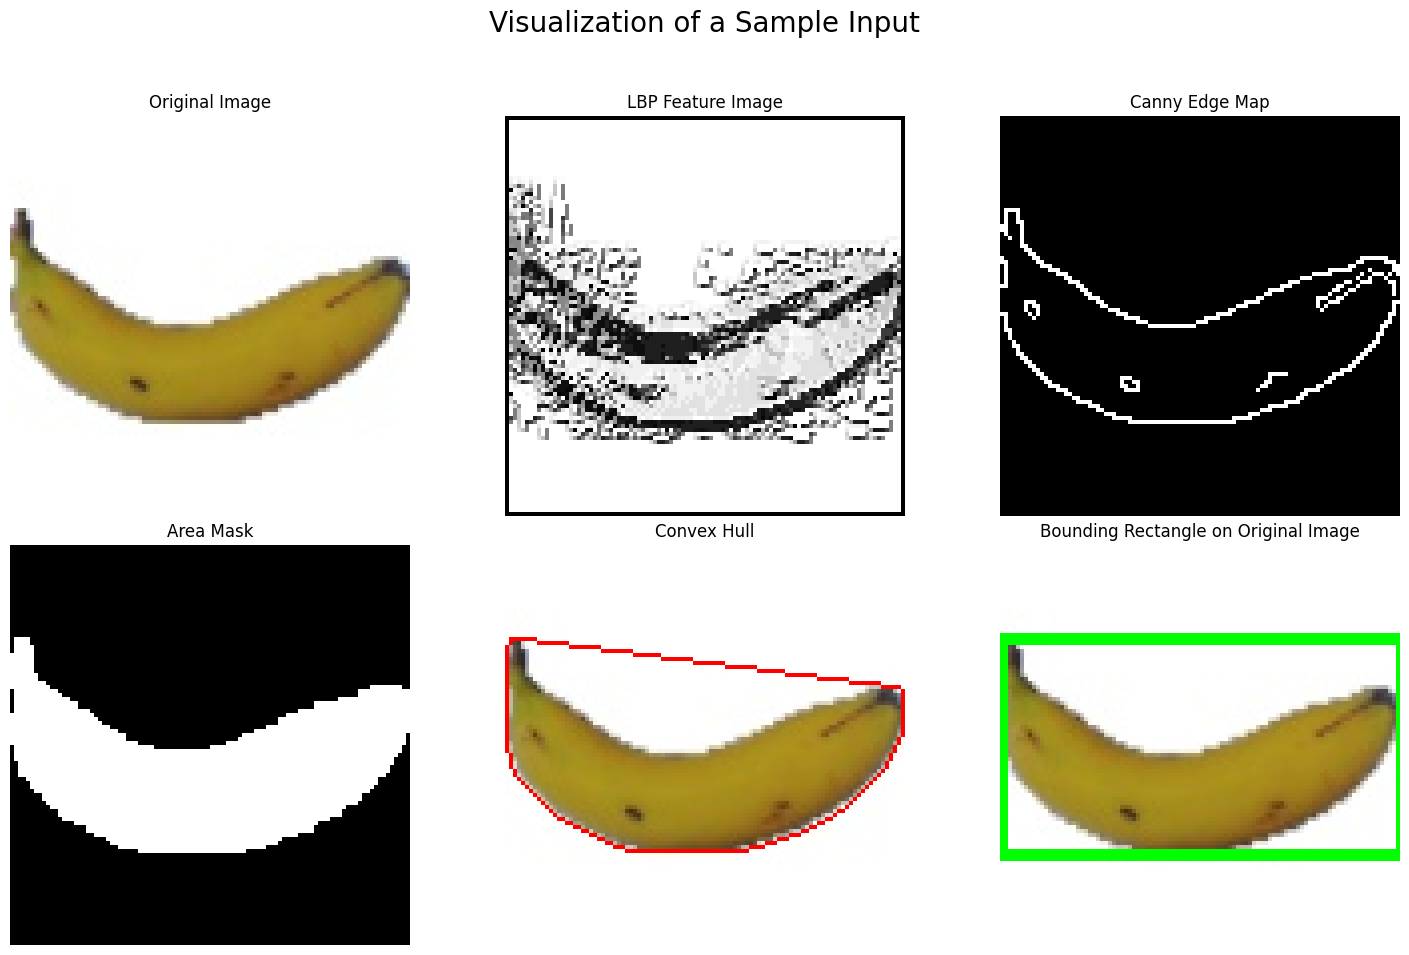

In [9]:
# Visualizing a sample image from training dataset
sample1_path = os.path.join(training, "Banana 1", "117_100.jpg")
visualize(sample1_path)

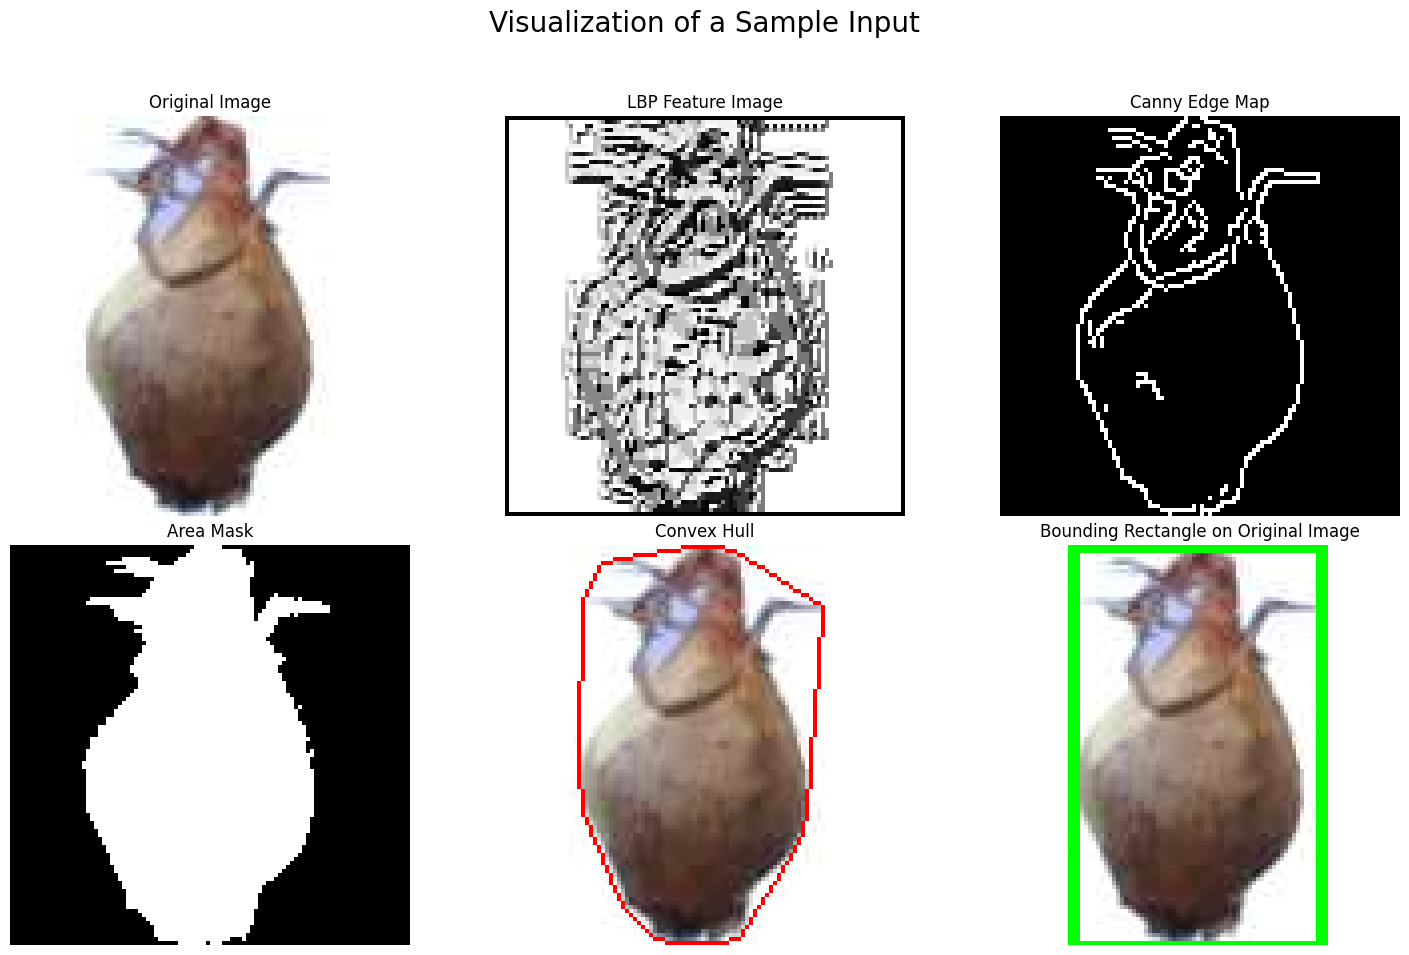

In [10]:
# Visualizing another sample image from training dataset
sample2_path = os.path.join(training, "Onion 2", "r0_101_100.jpg")
visualize(sample2_path)

In [11]:
# Next, we define the Dataset, DataLoader and feature extraction pipeline

In [12]:
# Takes RGB Image and returns the 6 color features

def extract_color_features(img):

    # Convert RGB to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # Mean Hue (Feature 1)
    mean_h = np.mean(h)

    # Standard Deviation of Hue (Feature 2)
    std_h = np.std(h)

    # Mean Saturation (Feature 3)
    mean_s = np.mean(s)

    # Standard Deviation of Saturation (Feature 4)
    std_s = np.std(s)

    # Mean Value (Feature 5)
    mean_v = np.mean(v)

    # Standard Deviation of Value (Feature 6)
    std_v = np.std(v)

    return np.array([mean_h, std_h, mean_s, std_s, mean_v, std_v])

In [13]:
# Takes Grayscale Image and returns the 6 shape features

def extract_shape_features(gray):

    # Since the fruits have white background, we will use binary mask for extracting shape features
    _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV)  # Creating binary mask

    # Contour Detection in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If no contour is detected, return all features as zero
    if not contours:
        return np.zeros(6)

    # Contour with largest Area
    cnt = max(contours, key=cv2.contourArea)

    # Contour Area
    area = cv2.contourArea(cnt)

    # Perimeter of Contour
    perimeter = cv2.arcLength(cnt, True)

    # Image Area
    img_area = gray.shape[0] * gray.shape[1]

    # Area Ratio (Feature 1)
    area_ratio = area / img_area

    # Bounding Box
    x, y, w, h = cv2.boundingRect(cnt)

    # Aspect Ratio (Feature 2)
    aspect_ratio = w / h if h > 0 else 0

    # Computes Convex Hull
    hull = cv2.convexHull(cnt)

    # Convex Hull Area
    hull_area = cv2.contourArea(hull)

    # Solidity (Feature 3)
    solidity = area / hull_area if hull_area > 0 else 0

    # Circularity (Feature 4)
    circularity = 4 * np.pi * area / (perimeter ** 2 + 1e-10)

    # Hu Moments
    moments = cv2.moments(cnt)
    hu = cv2.HuMoments(moments).flatten()

    # Log-scale for numerical stability

    # Hu_1 (Feature 5)
    hu_1 = -np.sign(hu[0]) * np.log10(np.abs(hu[0]) + 1e-10)

    # Hu_2 (Feature 6)
    hu_2 = -np.sign(hu[1]) * np.log10(np.abs(hu[1]) + 1e-10)

    # Used offset value of 10^(-10) in order to avoid exact zero inside the logarithm,otherwise it might blow up

    return np.array([area_ratio, aspect_ratio, solidity, circularity, hu_1, hu_2])

In [14]:
# Dataset Loader

class Fruit360_DataLoader(Dataset):
    def __init__(self, path):

        # To store (img_path,label) tuples
        self.samples = []

        # Mapping class names to integer label
        self.class_to_idx = {}

        # Get sorted list of class folders
        classes = sorted(os.listdir(path))

        # Assign index to each class

        for idx, cls in enumerate(classes):
            self.class_to_idx[cls] = idx
            cls_path = os.path.join(path, cls)

            # Iterating over all image in the class folder
            for img in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img)
                self.samples.append((img_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        # Get image path and corresponding label
        img_path, label = self.samples[idx]

        # Read image and conversion to RGB format
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize for consistent input dimensions (images are already 100x100)
        img = cv2.resize(img, (100, 100))

        # Conversion to Grayscale Image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Get LBP features
        lbp = get_lbp(gray)

        # Get Canny Edge Map
        canny = get_canny(gray)

        # Extract 6 color features
        color_features = extract_color_features(img)

        # Extract 6 shape features
        shape_features = extract_shape_features(gray)

        # PyTorch expects image tensors of shape (C, H, W)
        img = torch.tensor(img).permute(2, 0, 1).float() / 255.0
        lbp = torch.tensor(lbp).unsqueeze(0).float() / 255.0
        canny = torch.tensor(canny).unsqueeze(0).float() / 255.0

        # Conversion to tensor
        color_features = torch.tensor(color_features).float()
        shape_features = torch.tensor(shape_features).float()
        label = torch.tensor(label, dtype=torch.long)

        # Return dictionary containing all modalities and label
        return {
            "rgb": img,                       # RGB image tensor (3 x H x W)
            "lbp": lbp,                       # LBP texture image (1 x H x W)
            "canny": canny,                   # Canny edge image (1 x H x W)
            "color_features": color_features, # Extracted color features (6,)
            "shape_features": shape_features, # Extracted shape features (6,)
            "label": label                    # Class label
        }

In [15]:
# Create dataset object for training and test set

train_dataset = Fruit360_DataLoader(training)
test_dataset = Fruit360_DataLoader(test)

In [16]:
# DataLoader for training dataset

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,   # Shuffle data at every epoch to improve generalization
    num_workers=2,  # Number of subprocesses for data loading
    pin_memory=True)

In [17]:
# DataLoader for test dataset

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True)

In [18]:
batch = next(iter(train_loader))

# Display shapes of all modalities in a batch to verify correct batching
for k, v in batch.items():
    print(f"{k:<20} {tuple(v.shape)}")

rgb                  (32, 3, 100, 100)
lbp                  (32, 1, 100, 100)
canny                (32, 1, 100, 100)
color_features       (32, 6)
shape_features       (32, 6)
label                (32,)


In [19]:
# Verify that the number of classes matches the original dataset (237 classes)

labels = [label for _, label in train_dataset.samples]
unique_labels = sorted(set(labels))
print(len(unique_labels))

237


Color features: tensor([ 17.0581,  26.8359,  19.4980,  25.6698, 181.9647,  87.7366])
Shape features: tensor([0.4121, 0.6907, 0.9442, 0.6683, 0.7655, 2.5924])


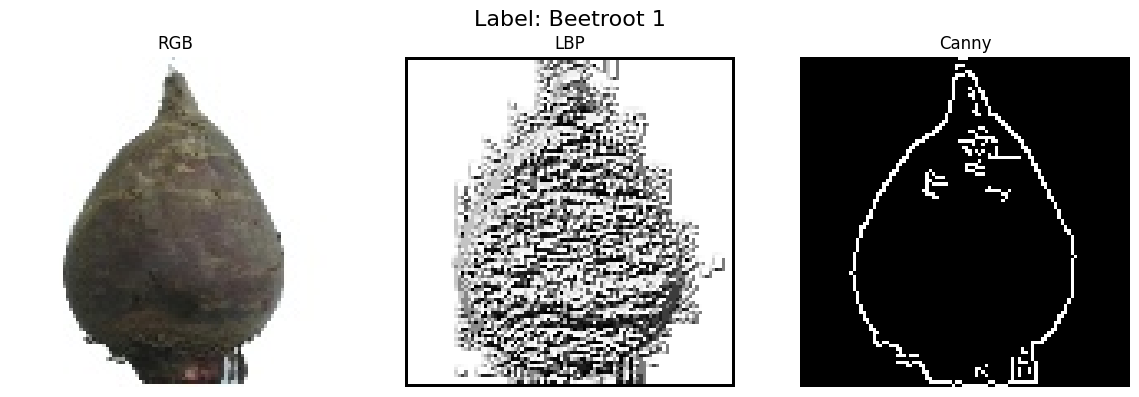

In [20]:
# Viewing what is returned from DataLoader
random_idx = np.random.randint(0, len(train_dataset))
sample = train_dataset[random_idx]

# Print features
print("Color features:", sample["color_features"])
print("Shape features:", sample["shape_features"])

# Convert tensors to numpy for visualization
rgb = sample["rgb"].permute(1, 2, 0).numpy()
lbp = sample["lbp"].squeeze(0).numpy()
canny = sample["canny"].squeeze(0).numpy()

# Get label name
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
label_name = idx_to_class[sample["label"].item()]

# Display
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.title(f"RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(lbp, cmap="gray")
plt.title("LBP")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(canny, cmap="gray")
plt.title("Canny")
plt.axis("off")

plt.suptitle(f"Label: {label_name}", fontsize=16)
plt.tight_layout()
plt.show()

# Limitations:

* Correct predictions suggest effective visual representation, while errors often arise from overlapping color or shape properties across classes.

* Since the approach relies on handcrafted visual features, it may be sensitive to significant illumination changes and may not fully capture complex spatial relationships present in images. Additionally, reducing images to compact feature vectors inherently leads to loss of detailed structural information.
